In [55]:
# !pip install osmnx

In [3]:
import osmnx as ox
import networkx as nx
import pandas as pd

In [4]:
df = pd.read_parquet("../data/valenbici_2025.parquet")

In [3]:
# Coordenadas de inicio y destino
vlc = (39.4699, -0.3763)     # Ejemplo: Valencia centro

# Descargar grafo de Valencia (peatonal o bicicleta)
#Esto se ejecuta antes de la interacción con el usuario
G = ox.graph_from_point(vlc, dist=3000, network_type='bike', simplify=True)  # 'walk', 'drive', etc.

In [9]:
#Se ejecuta antes
coord_vb = {(float(x.split(',')[0]), float(x.split(',')[1])) for x in df['geo_point_2d']}

In [12]:
xs = [coord[1] for coord in coord_vb]
ys = [coord[0] for coord in coord_vb]

In [17]:
def ruta_a_origen(G, coord_vb, origen_nodo):
    # Paso 1: Obtener nodos de coord_vb en bloque
    nodos_vb = ox.nearest_nodes(G, xs, ys)
    coord_nodo_map = dict(zip(nodos_vb, coord_vb))

    # Paso 2: Evita nodo origen si está en las coords (lo tratamos aparte si hace falta)
    nodos_vb_filtrados = set(nodos_vb) - {origen_nodo}

    # Paso 3: Calcular rutas desde origen_nodo a todos los nodos posibles
    longitudes = nx.single_source_dijkstra_path_length(G, origen_nodo, weight='length')

    mejor_coord = None
    longitud_minima = float('inf')

    for nodo in nodos_vb_filtrados:
        if nodo in longitudes and longitudes[nodo] < longitud_minima:
            longitud_minima = longitudes[nodo]
            mejor_coord = coord_nodo_map[nodo]

    # Paso 5 (opcional): tratar el caso donde origen ya es uno de los nodos objetivo
    if origen_nodo in coord_nodo_map:
        mejor_coord = coord_nodo_map[origen_nodo]
        longitud_minima = 0

    return mejor_coord

In [ ]:
def ruta_a_destino(G, coord_vb, destino_nodo):
    # Paso 1: Obtener nodos de coord_vb vectorizado
    nodos_vb = ox.nearest_nodes(G, xs, ys)
    coord_nodo_map = dict(zip(nodos_vb, coord_vb))

    # Paso 2: Quitar nodo destino (a menos que queramos comprobarlo aparte)
    nodos_vb_filtrados = set(nodos_vb) - {destino_nodo}

    # Paso 3: Calcular rutas desde destino_nodo a todos los demás nodos
    longitudes = nx.single_source_dijkstra_path_length(G, destino_nodo, weight='length')

    mejor_coord = None
    longitud_minima = float('inf')

    for nodo in nodos_vb_filtrados:
        if nodo in longitudes and longitudes[nodo] < longitud_minima:
            longitud_minima = longitudes[nodo]
            mejor_coord = coord_nodo_map[nodo]

    # Caso especial: el destino está entre las coordenadas
    if destino_nodo in coord_nodo_map:
        mejor_coord = coord_nodo_map[destino_nodo]
        longitud_minima = 0
    
    return mejor_coord

In [39]:
def crear_ruta(G, coord_vb, origen, destino):
    origen_nodo = ox.nearest_nodes(G, origen[1], origen[0])
    destino_nodo = ox.nearest_nodes(G, destino[1], destino[0])

    est_origen = ruta_a_origen(G, coord_vb, origen_nodo)
    est_destino = ruta_a_destino(G, coord_vb, destino_nodo)

    est_origen_nodo = ox.nearest_nodes(G, est_origen[1], est_origen[0])
    est_destino_nodo = ox.nearest_nodes(G, est_destino[1], est_destino[0])

    pre_ruta = nx.shortest_path(G, origen_nodo, est_origen_nodo, weight='length')
    ruta = nx.shortest_path(G, est_origen_nodo, est_destino_nodo, weight='length')
    post_ruta = nx.shortest_path(G, est_destino_nodo, destino_nodo, weight='length')

    return pre_ruta, ruta, post_ruta

In [40]:
origen = (39.484209, -0.397515)
destino = (39.477677, -0.343838)

pre_ruta, ruta, post_ruta = crear_ruta(G, coord_vb, origen, destino)

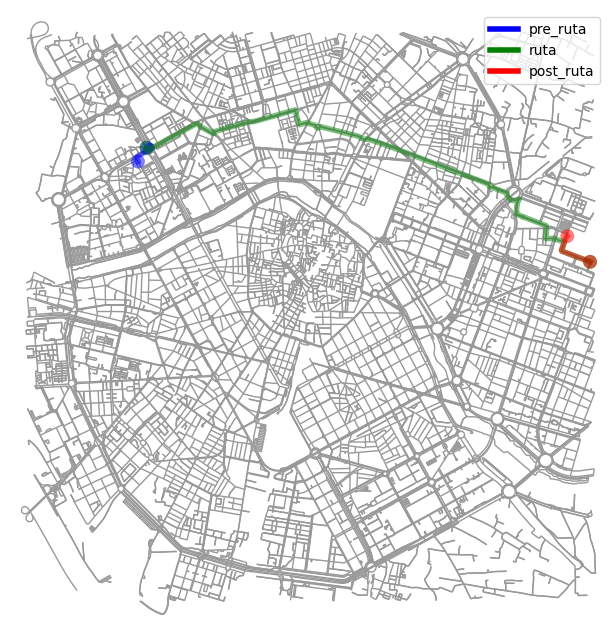

In [41]:
import matplotlib.pyplot as plt

# Asegúrate de que estas rutas existen y son listas de nodos
rutas = [pre_ruta, ruta, post_ruta]
colores = ['blue', 'green', 'red']
etiquetas = ['pre_ruta', 'ruta', 'post_ruta']

# Dibujar el grafo con las rutas
fig, ax = ox.plot_graph_routes(
    G, rutas,
    route_colors=colores,
    route_linewidth=4,
    node_size=0,
    show=False,
    close=False,
    bgcolor='white'
)

# Opcional: añadir leyenda personalizada
for color, label in zip(colores, etiquetas):
    ax.plot([], [], color=color, linewidth=4, label=label)
ax.legend()

plt.show()